# Table of Contents
- [Dynamic Time Patterns for Algorithmic Trading using Machine Learning](#dynamic-time-patterns-for-algorithmic-trading-using-machine-learning)
  - [Setup and Preprocessing](#setup-and-preprocessing)
    - [Environment Setup](#environment-setup)
  - [Math Behind the Algorithm](#math-behind-the-algorithm)
    - [Distance Metrics](#distance-metrics)
    - [K-Nearest Neighbor Algorithm](#k-nearest-neighbor-algorithm)
  - [Simple Backtest of Forecast Predictions](#simple-backtest-of-forecast-predictions)
    - [Backtest Strategy](#backtest-strategy)
  - [Results and Visualization](#results-and-visualization)
  - [Conclusion](#conclusion)

# Dynamic Time Patterns using KNN

 Time series forecasting plays a critical role in various fields, from predicting weather patterns to anticipating stock market movements. One intuitive approach to forecasting is to look for similar patterns in the past and assume that what followed those patterns might occur again. The k-Nearest Neighbors (KNN) algorithm operationalizes this idea. As a non-parametric, instance-based learning method, KNN makes predictions for a new data point (or sequence) by examining the 'k' most similar/nearest 'neighbors' in the historical data.

 The nearest neighbors can be found in different ways using various distance metrics, each capturing different aspects of similarity in time series data. The choice of distance metric significantly impacts the effectiveness of the KNN model. Some commonly used metrics include: Euclidean Distance, Mean Squared Error Distance (MSED), Dynamic Time Warping (DTW), and Complexity-Invariant Distance (CID).
 
 This notebook serves as an educational exploration into KNN for time series forecasting, focusing on the impact of these different distance metrics. It will cover:
 - Preprocessing, such as EMA smoothing and standardization. These are used to reduce noise as much as possible, yet reduce real application of the forecasting.
 - Math and implementation of distance metrics.
 - Knn algorithm and its parameters when using sequential data.
 - Evaluation through different error metrics.
 - parameter optimization using gridsearch.


## Setup and Preprocessing
To run algorithm, import libraries, and initialize data. 

The time-interval used (1-month of data) and the parameters, make the algorithm/predictions take roughly 20 minutes.



### Environnment Setup
Install the required libraries using:

In [19]:
pip install numpy pandas matplotlib fastdtw scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


### Data Collection
For this project, high-frequency forex data has been used, soruced from Metatrader.

It is downloaded as 1 minute data, which is being changed to 5-minute intervals, where the Closing price of the asset will be used for the return. The data has the Time, Open, High, Low and Closing price.

In the case of the example of the algorithm, the GBP/USD data is used, with the time period March 1, 2021 00:00 to march 31, 2021 23:55.

In [72]:
df = pd.read_csv("gbp_usd_5min.csv", parse_dates=["Time"])

# Sort the index to ensure monotonicity
df.set_index("Time", inplace=True)
df = df.sort_index()

# date-range of data that will be used
start_date = "2021-03-01 00:00"
end_date = "2021-03-31 23:55"

# Define range of df to be used based on dates
df = df.loc[start_date:end_date]

print(df.tail())


                        Open     High      Low    Close
Time                                                   
2021-03-31 23:35:00  1.37813  1.37822  1.37796  1.37808
2021-03-31 23:40:00  1.37809  1.37821  1.37796  1.37815
2021-03-31 23:45:00  1.37813  1.37827  1.37796  1.37826
2021-03-31 23:50:00  1.37826  1.37835  1.37814  1.37827
2021-03-31 23:55:00  1.37826  1.37827  1.37807  1.37813


### data preprocessing

Checking for missing values:

In [73]:
print(df.isna().sum())


Open     0
High     0
Low      0
Close    0
dtype: int64


Logarithmic returns are computed based on closing price at time $t$ divided by closing price at time $t+1$.

In [74]:
df["returns"] = np.log(df["Close"] / df["Close"].shift(1))
df.dropna(inplace=True)

#### Smoothing Returns Using Exponential Moving Average

The returns are smoothed using exponential moving average.
The Exponential Moving Average (EMA) is a weighted moving average that gives more significance to recent data points, making it more responsive to price changes compared to a simple moving average (SMA). This reduces the noise of the data, which leads to mor erobust predictions. The problem is that this will lead to less representation of actual high frequency return, as their volatility can be very high. 

##### Formula:
$
EMA_t = \alpha \cdot R_t + (1 - \alpha) \cdot EMA_{t-1}
$

where:
- $ EMA_t $ is the exponential moving average at time $ t $,
- $ R_t $ is the return at time \( t \),
- $ \alpha $ is the smoothing factor, calculated as:
  $
  \alpha = \frac{2}{span + 1}
  $
- $ span $ is the chosen period for smoothing.

The smoothing factor $ \alpha $ determines how much weight recent returns receive. A higher $ \alpha $ (lower span) makes the EMA react more to new data, while a lower $ \alpha $ (higher span) results in a smoother curve. [1]

The implementation in python is as followed:

In [75]:
def apply_ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

df["ema_returns"] = apply_ema(df["returns"], span=15)
df.dropna(inplace=True)
print(df["ema_returns"].head())

Time
2021-03-01 00:05:00    0.000007
2021-03-01 00:10:00    0.000052
2021-03-01 00:15:00    0.000035
2021-03-01 00:20:00    0.000022
2021-03-01 00:25:00    0.000031
Name: ema_returns, dtype: float64


To validate the function’s correctness (and to show the formula calculation in python), the EMA of return 100 is calculated and compared to the output from apply_ema():

In [76]:
span = 15
EMA_return_100 = 2/(span+1) * df["returns"].iloc[100] + (1 - 2/(span+1)) * df["ema_returns"].iloc[99]
if EMA_return_100 == df.iloc[100]["ema_returns"]:
    print("🎉🎉🎉")
print("Manual EMA:", EMA_return_100)
print("apply_ema() EMA:", df["ema_returns"].iloc[100])

🎉🎉🎉
Manual EMA: -0.00019552803368233756
apply_ema() EMA: -0.00019552803368233756


#### Standardizing EMA Returns Using Rolling Standard Deviation
Standardization is used to normalize data by adjusting for variations in scale and volatility, making it easier to compare values across different time, allowing the detection of regime shifts.

$
\sigma_t = \sqrt{\frac{1}{w} \sum_{i=t-w+1}^{t} (EMA_i - \bar{EMA})^2}
$

where:

- $ \sigma_t $ is the rolling standard deviation at time $ t $,
- $ EMA_i $ are the exponential moving averages within the window,
- $ \bar{EMA} $ is the mean EMA within the window,
- $ w $ is the window size.

standardize the EMA returns:

$
EMA_{std,t} = \frac{EMA_t}{\sigma_t}
$

In this case the window is 120.

The implementation in python is as followed:

In [77]:
std_window_size = 120
df["rolling_std"] = df["ema_returns"].rolling(window=std_window_size, min_periods=std_window_size).std()
df.dropna(subset=["rolling_std"], inplace=True)
df["std_ema_returns"] = df["ema_returns"] / (df["rolling_std"] + 1e-9)

In [78]:
print(df["std_ema_returns"].max())
print(df["std_ema_returns"].min())
print(df["ema_returns"].max())
print(df["ema_returns"].min())

5.335439295883389
-5.087464059389603
0.00045468557104647077
-0.00039797512389973385


Volatility-adjusted, standardized EMA returns roughly range between ±5.

Non-standardized EMA returns are approximately between ±0.0004, which is very low in magnitude.

Data preprocessing ensures that the time series is clean and standardized, enabling the mathematical models to operate effectively. With the data prepared, the mathematical foundation of the algorithm can be explored.

## Algorithm and Mathematical Foundation

The core of this project is a k-Nearest Neighbors (kNN) model applied to time series forecasting. By identifying the closest historical patterns, one can predict future returns

These predictions accuracy will be assessed using NMAE, comparing the different distance metrics used in KNN.

### Introduction to K-Nearest-Neighbor Algorithm

KNN algorithm is commonly used for classifying data points, but can also be applied to time series forecasting by identifying the most similar past sequences.

KNN works by directly comparing a new data point to historical examples, finding the k most similar instances (neighbors) based on a distance metric, such as Euclidean distance.

Imagine a brokerage firm wants to predict if a new investor is likely to sell their shares of Apple (AAPL) within the next month based on their trading history. They use KNN by looking at a dataset of past investors, where each is represented by a vector of the features: Number of trades in pas 30 days, average holding period, and portfolio size. For a new investor with 5 trades, a 10-day average hold, and a \$10,000 portfolio, KNN finds the 5 most similar past investors. If three of those sold AAPL within a month, the algorithm predicts this new investor is likely to dump their shares too.

In this case, KNN doesn’t rely on clusters or predefined groups—it’s all about proximity in the feature space. The choice of k (here, 5) balances between overfitting (too small a k) and smoothing out patterns (too large a k).



#### K-Means Clustering
A different algorithm, but very much alike, is the K-Means Algorithm. Instead of using a datapoint, finding nearest datapoints, quantifying a classification, centroid will be randomly placed, clustering the data.

A use case of this is Economic Segmentation:
A central bank wants to classify countries based on their economic stability to guide monetary policy decisions. It collects data on:

- GDP Growth Rate (%)

- Inflation Rate (%)

- Unemployment Rate (%)

- Foreign Exchange Reserves (in billion USD)

Using K-Means, the algorithm clusters countries into three economic categories:

1. Stable Economies – Low inflation, steady GDP growth, low unemployment, and high reserves.

2. Emerging Markets – High GDP growth but moderate inflation and unemployment, with moderate forex reserves.

3. Struggling Economies – High unemployment, high inflation, slow GDP growth, and low reserves.

This clustering helps policymakers adjust interest rates, set exchange rate policies, or provide financial aid to struggling economies.

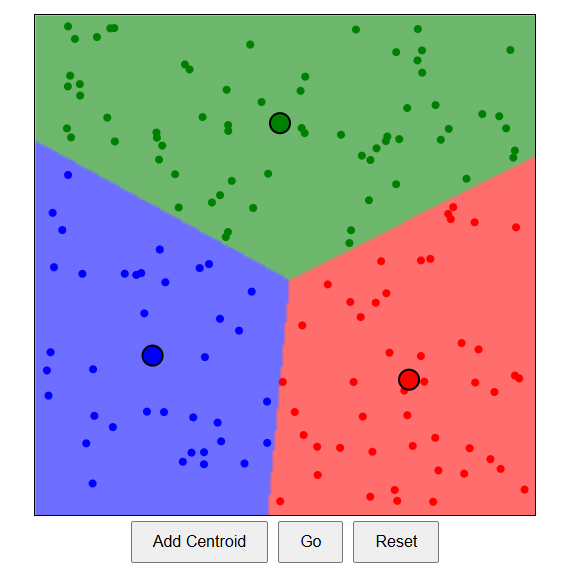

The image above is taken from my project @ https://kristofferjoha.github.io/ClusteringAlgos/, which visualizes the k-means algorithm. (can be slow due to grid resolution)

After having placed centroids, it iterates over the distances and clusters the datapoint, aiming for the shortest avg. distance to each datapoint.

To reference back to K-Nearest-Neighbour, if one imagines that the centroids (black outline) are datapoints in the KNN algorithm. You find the k-nearest datapoints and find the avg. value of what you are trying to predict. In the case of this algorithm, Dynamic Time Patterns, it would be Standardized EMA returns.

### Distance Metrics for Time Series Forecasting with kNN
When using k-Nearest Neighbors (kNN) for time series forecasting, the choice of distance metric is crucial. Since time series data contains temporal dependencies, standard measures like Euclidean distance may not always be effective.

Below are four commonly used distance metrics for comparing time series in forecasting models:

- Euclidean distance

- Dynamic Time Warping (DTW)

- Mean Squared Error Distance (MSED)

- Complexity-Invariant Distance (CID) 

Euclidean distance is the simplest and most commonly used, but more advanced metrics like DTW are better suited when time series exhibit shifts in timing or volatility. [2]

#### Euclidean distance

Euclidean measures the straight-line distance between two sequences of equal length, summing up the squared differences between corresponding points. [3]

##### Formula

Given two time series: $ X=(x_1, x_2, ...,x_n ) $ and $ =(y_1, y_2, ...,y_n)$, the euclidean distance between the two time series is:

$$D(X, Y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$$

- $x_i$ and $y_i$ are the values of the time series at the i-th element
- n is length of time series

Calculating distances between two arrays using euclidean can be implemented in python the following way:

In [28]:
# Defining two series
X = np.array([3,4,5,6])
Y = np.array([6,5,4,3])
X_easy = np.array([1, 2])
Y_easy = np.array([4, 6])

def euclidean_distance(X, Y):
    return np.sqrt(np.sum((X - Y) ** 2))

# Eucledean Distance
distance = euclidean_distance(X, Y)
distance_easy = euclidean_distance(X_easy, Y_easy)

print("Euclidean Distance:", distance)
print("Euclidean Distance Pythagoras:", distance_easy)


Euclidean Distance: 4.47213595499958
Euclidean Distance Pythagoras: 5.0


The "Pythagoras" example is included because it is easy to relate to. The distance between the points P(1,2) and P(4,6) is 5, based on the Pythagorean theorem where side lengths 3 and 4 give a hypotenuse length of 5.

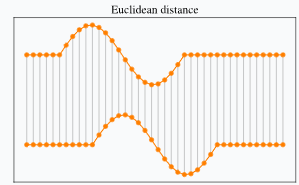

The picture from [4] shows euclidean distance for a time series. It compares each element with the corresponding value. The important thing here is that, as mentioned, the length of the two series must be equal.

#### Dynamic Time Warping (DTW)
DTW is a more flexible measure of distance between two time series, especially when they may be out of phase or have varying lengths. Unlike Euclidean distance, which assumes that the corresponding points in two sequences match up directly, DTW allows for the alignment of time series in a non-linear fashion.

DTW computes the minimum cumulative distance between two sequences by "warping" them to align the most similar points. This is done by comparing each element of one series with several elements of the other series, allowing for shifting, stretching, and compressing the time axis.

DTW has some steps to it [5]:

- Step 1: Distance Matrix construction
Use euclidean or other metric to construct a distance matrix between the two sequences.

$$D(i,j)=dist(x_i,y_j)$$

Calculate distance for each value in matrix D

$$
D= \begin{pmatrix}
  dist(x_1,y_1) & dist(x_1,y_2) & ... & dist(x_1,y_m) \\
  dist(x_2,y_1) & dist(x_2,y_2) & ... & dist(x_2,y_m) \\
  \vdots & \vdots & \ddots & \vdots \\
  dist(x_n,y_1) & dist(x_n,y_2) & ... & dist(x_n,y_m)
\end{pmatrix}
$$

- Step 2: Cumulative Cost Matrix
Next step is to calculate the cumulative cost matrix, which keeps track of the minimum cumulative distance at each point, considering all previous points in both sequences

Based on the distance matrix D, the cost for each point (i,j) is the $x_i $ and $y_j$ distance, plus the minimum cumulative distance from previous step.

The recursive formula is as followed:

$$D(i,j)=dist(x_i,y_j) + min(C(i-1,j),C(i,j-1),C(i-1,j-1))$$

- $C(i-1,j)$ represents vertical movement
- $C(i,j-1)$ represents horizontal movement
- $C(i-1,j-1)$ represents diagonal movement


$$
C= \begin{pmatrix}
  C(1,1) & C(1,2) & ... & C(1,m) \\
  C(2,1) & C(2,2) & ... & C(2,m) \\
  \vdots & \vdots & \ddots & \vdots \\
  C(n,1) & C(n,2) & ... & C(n,m)
\end{pmatrix}
$$

The value for $(n,m)$ gives total comulative distance between two time series with best alignment.

- Step 3: path finding

With the comulative cost matrix C, it is time to find the optimal warping path. This means finding the path from C(n,m) to C(1,1) by following the minimum values.

This is done by moving one step at a vertically, horizontally, or diagonally based on minimum cost.

- Step 4: DTW Distance Calculation

The DTW distance is that which gives the minimum comulative cost to align the two time series.

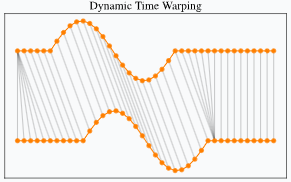

The picture from [4] shows Dynamic type warping distance for a time series. Two time series with different length are being compressed and streched to fit optimally with one another.

fastdtw, an approximate Dynamic Time Warping algorithm, will be used for the dynamic time warping for this project.



#### Mean Squared Error Distance (MSE Distance)
This distance metric utilizes the Mean Squared Error (MSED) calculation, often employed for evaluating regression models, as a measure of dissimilarity between two time series sequences of equal length. It computes the average of the squared differences between corresponding points.

While related to Euclidean distance (which involves summing squared differences before taking a square root), MSED Distance provides the average squared difference directly. This value represents the variance of the point-wise differences between the two series.

##### Formula
Given two time series: $ X=(x_1, x_2, ...,x_n ) $ and $ =(y_1, y_2, ...,y_n)$, the MSE distance between the two time series is:

$$MSED(X, Y) = \frac{1}{n}\sum_{i=1}^{n} (x_i - y_i)^2$$

- $x_i$ and $y_i$ are the values of the time series at the i-th element
- n is length of time series

MSED for calculating distances between two arrays can be implemented in python the following way:

In [29]:
# Defining two series
X = np.array([3,4,5,6])
Y = np.array([6,5,4,3])

# MSED calculation
def mean_absolute_error_distance(X, Y):
    return np.mean((X - Y) ** 2)

mse = mean_absolute_error_distance(X, Y)

print("Mean Squared Error Distance:", mse)

Mean Squared Error Distance: 5.0


This value is derived from the same squared differences used in the Euclidean calculation but represents the mean squared error distance instead of the square root of the total sum. They give roughly the same distance in the case of those two arrays. To show how MSED is more sensitive to the large outlier, a different example can be shown, where the difference at one index is increased dramatically.

In [30]:
# Defining two series
X_volatile = np.array([3,4,5,15])
Y = np.array([6,5,4,3]) # Same Y array as before

# MSED calculation
def mean_absolute_error_distance(X, Y):
    return np.mean((X - Y) ** 2)

mse = mean_absolute_error_distance(X_volatile, Y)
euc = euclidean_distance(X_volatile, Y)

print("Mean Squared Error Distance:", mse)
print("Euclidean Distance:", euc)

Mean Squared Error Distance: 38.75
Euclidean Distance: 12.449899597988733


The examples above illustrate how MSED Distance penalizes large point-wise differences between sequences more heavily than Euclidean distance.

CID accounts for the complexity of time series. This could be the volatility of two time series, where they have similar values but move differently. The goal of CID is to adjust the distance measure so that time series with similar complexity are considered closer, even if their raw distances (for example, Euclidean) differ.

It uses, let's say euclidean distance of two time series, and introduces a correction factor, making them complexity-invariant.

##### Formula

Given two time series: $ X=(x_1, x_2, ...,x_n ) $ and $ =(y_1, y_2, ...,y_n)$, the CID distance between the two time series is:

$$CID(X,Y)= ED(X,Y) \times CF(X,Y)$$

- $ED(X,Y)$ Calculates euclidean distance between time series X and Y.
- $CF(X,Y)$ is the complexity correction factor.

The correction factor can be defined as followed:

$$CF(X,Y) = \frac{max(CE(X),CE(Y))}{min(CE(X),CE(Y))}$$

This includes CE(Q), which is the complexity estimates of a time series. 

$$ CE(Q) = \sqrt{\sum_{i=1}^{n-1} (q_i - q_{i+1})^2} $$

Here Q is a placeholder for the time series X and Y, since this formula looks at each individual time series.

So $CE()$ calculates the interval volatility/variation of a single time series, whereas $CF()$ compares the complexities, the volatilities, of the two time series.

- If $CE(X)$ is similar to $CE(Y)$: The ratio $\frac{max(CE(X),CE(Y))}{min(CE(X),CE(Y))}$ will be close to 1, and CID(X,Y) will be approximately equal to ED(X,Y). 
In this case, the complexity of the two series is similar, so the standard Euclidean distance is a reasonable measure.
- If $CE(X)$ is significantly different from $CE(Y)$: The ratio will be greater than 1, increasing the CID(X,Y) compared to ED(X,Y). This penalizes distances between time series with different complexity, ensuring that smooth vs. highly volatile series are recognized as fundamentally different.

Unlike raw Euclidean distance, CID helps compare time series fairly when they have different levels of complexity, which is very useful when comparing stocks with different volatilities etc...

CID for calculating distances between two arrays can be implemented in python the following way:

In [31]:
# Defining two series
X = np.array([3, 4, 5, 6])
Y = np.array([6, 5, 4, 3])


# Complexity Estimate (CE) function
def complexity_estimate(series):
    return np.sqrt(np.sum(np.diff(series) ** 2))

# Complexity Factor (CF) function
def complexity_factor(X, Y):
    CE_X = complexity_estimate(X)
    CE_Y = complexity_estimate(Y)
    return max(CE_X, CE_Y) / min(CE_X, CE_Y)

# CID function
def CID(X, Y):
    ED = euclidean_distance(X, Y)  # Euclidean Distance (one from previous example of euclidean metric)
    CF = complexity_factor(X, Y)   # Calculate Complexity Factor
    return ED * CF  # return product

# Calculating CID for X and Y
cid_value = CID(X, Y)
print("CID:", cid_value)
euc_value=euclidean_distance(X, Y) 
print("Euclidean Distance:", euc_value)

CID: 4.47213595499958
Euclidean Distance: 4.47213595499958


In this case, both the Euclidean Distance (ED) and the Complexity-Invariant Distance (CID) return the same value. This happens because the volatility (or complexity) of X and Y is identical, meaning the Complexity Factor (CF) equals 1.
Changing the value of an element in the array X will make the volatility differ between the two arrays.

In [32]:
# Defining two series
X = np.array([12, 4, 5, 6])
Y = np.array([6, 5, 4, 3])


# Calculating CID for new X and Y, where volatility is higher
cid_value = CID(X, Y)
print("CID:", cid_value)
euc_value=euclidean_distance(X, Y)
print("Euclidean Distance:", euc_value)

CID: 32.155870381627054
Euclidean Distance: 6.855654600401044


In the second example, the CID value sees a large increase compared to euclidean distance because the volatility (complexity) of the time series X is now higher than before.

For the KNN usage of these metrics, it pretty much uses the same functions described above. There are though some differences due to error handling being applied some places. 

- Euclidean Distance: This metric is not explicitly displayed here, as the KNN algorithm has a built-in function for computing Euclidean distance, making a separate implementation unnecessary.
- Dynamic Time Warping (DTW): As previously mentioned, the FastDTW library is used for DTW-based predictions. FastDTW is an optimized version of traditional DTW, offering significant improvements in computational efficiency while still preserving accuracy. 
- Mean Squared Error Distance (MSED): This metric is implemented as previously shown
- Complexity-Invariant Distance (CID): Implemented as previously shown, with the exception that error handling is added for volatility of 0. For example, the array X=[3,3,3] would have a min $min(ce_x, ce_y)$ of 0. The safeguard is there to make sure it does not divide by 0.

In [33]:
def dtw_metric(x, y):
    distance, _ = fastdtw(x, y)
    return distance

fastdtw returns a tuple constisting of distance and path. The path isn't interesting...

In [34]:
def msed_metric(x, y):
    return np.mean((x - y) ** 2)

Same as before

In [35]:
# Complexity Estimate (CE) function
def complexity_estimate(series):
    return np.sqrt(np.sum(np.diff(series) ** 2))

# Complexity Factor (CF) function
def complexity_factor(X, Y):
    CE_X = complexity_estimate(X)
    CE_Y = complexity_estimate(Y)
    if min(CE_X, CE_Y) == 0: # safeguard against division by zero
        return 1.0
    return max(CE_X, CE_Y) / min(CE_X, CE_Y)

# CID function
def cid_metric(X, Y):
    ED = euclidean_distance(X, Y)  
    CF = complexity_factor(X, Y)   
    return ED * CF  

Added safeguard

### KNN Forecasting Algorithm

#### Parameters
As mentioned, KNN finds the nearest neighbors to the data you are trying to predict, in this case a part of a time series. To implement it, the following parameters are needed:

- **series**: The time series data on which the forecast will be made. 
- **window_size (default 240)**: Defines the size of the historical window from which the nearest neighbors will be drawn. It controls how many past data points are considered when finding similar patterns.
- **embed_size (default 15)**: The size of the embedding window. It represents the length of the time series subsequence used for each neighbor comparison.
- **k (default 20)**: The number of nearest neighbors used to generate the prediction.
- **metric**: The distance metric used to calculate the "closeness" of the neighbors.

#### Algorithm Overview
The algorithm operates by sliding a window over the time series data, extracting subsequences of a fixed length (embed_size). These subsequences are compared to previous patterns found within a larger historical window (window_size). The similarity between subsequences is determined using a specified distance metric, such as MSE, CID, DTW, or Euclidean distance.

For each prediction step, the algorithm follows these key steps:

1. **Extract the Query:**

- A query subsequence of length $ m $ (where $ m = \text{embed\_size}$ ) is extracted from the current time series data. This subsequence represents the recent historical pattern before the point being predicted.

- Mathematically, the query subsequence $ Q $ at time $ t $ is defined as:

  $$
  Q_t = [X_{t-m}, X_{t-m+1}, ..., X_{t-1}]
  $$

  where $ X_t $ represents the time series values at time step $ t $ in which you want to predict, and the subsequence consists of the last $ m $ values before $ t $.

2. **Extract the historical window:**
- The historical window consists of all past time series values up to the point where the prediction is being made, excluding the query subsequence. It is used to find similar patterns in past data.

- Mathematically, the historical window $H_t$ at time $t$ is defined as:

  $$
  H_t = [X_0, X_1, ..., X_{t-m-1}]
  $$

  where $X_t$ represents the time series values at time step $t$, and the historical window consists of all past values up to $t - m - 1$. 

  - Essentially, it looks before the embed size and one extra index, since that is the one you are trying to predict

3. **Ensure Sufficient Data for Prediction:**

- If the available historical data is less than window_size, a placeholder value (zero) is appended to the predictions, and the algorithm moves to the next step.

4. **Generate Historical Embeddings:**

- From the historical window, we extract overlapping subsequences of length $m$ (where $m = \text{embed\_size}$). These subsequences serve as the basis for identifying similar patterns.

- Since the historical window does not always start at $t - w$, the valid starting index $j$ is determined as:

  $$
  j_{\text{start}} = \max(0, t - w)
  $$

  ensuring that we do not exceed available historical data.

- Each subsequence is then defined as:

  $$
  S_j = [X_j, X_{j+1}, ..., X_{j+m-1}], \quad \forall j \in [j_{\text{start}}, t - m]
  $$

  where:
  - $w$ (window size) determines the **maximum** lookback period.
  - $j$ iterates over valid indices in the historical window, ensuring we extract all possible subsequences of length $m$.

5. **Find the Nearest Neighbors:**

- K-Nearest Neighbors model is initialized with k neighbors, using the selected distance metric. The model is an instance of the NearestNeighbors class from the sklearn.neighbors module from the scikit-learn library.

- The historical embeddings are fitted to this model.

- The algorithm finds the k closest subsequences, which represent the most similar patterns to the query.

6. **Extract Corresponding Future Values:**

- Once the nearest neighbors are identified, the algorithm retrieves the actual values that immediately follow each matched subsequence.

7. **Compute the Weighted Average Prediction:**

- The forecast is obtained by computing a weighted average of the retrieved values.

- Let the predicted value be $ \hat{y}_t $, which is the weighted average of the future values $ y_{t+k} $ corresponding to the k nearest neighbors:

  $$
  \hat{y}_t = \frac{\sum_{i=1}^{k} w_i \cdot y_{t+k_i}}{\sum_{i=1}^{k} w_i}
  $$

  where:
  - $ w_i = \frac{1}{d_i + \epsilon} $ is the weight for each neighbor, with $d_i$ being the distance between the query subsequence and the $i$-th neighbor, and $\epsilon$ is a small constant added to avoid division by zero.
  - $ y_{t+k_i} $ is the future value corresponding to the $i$-th nearest neighbor.
  - $ k $ is the number of nearest neighbors.

8. **Store the Prediction and Move Forward:**

- The computed prediction is appended to the results list.

- The process continues until predictions have been made for all possible points in the time series.

9. **Return the Final Predictions:**

- The function returns a list of predictions, ensuring that the initial part of the series (where predictions couldn't be made) is filled with zeros to maintain alignment with the original time series.

#### Python Implementation
Below is the python implementation for the algorithm:

In [ ]:
def knn_forecast(series, window_size=240, embed_size=15, k=20, metric=dtw_metric): # Default values for window_size, embed_size, k, and metric.
    predictions = []
    start_pred_index = window_size + embed_size

    # Uses tqdm for progress bar.
    for i in tqdm(range(start_pred_index, len(series)), desc=f"KNN Forecast ({metric if isinstance(metric, str) else metric.__name__})"): # Loop through the series starting from the index where predictions can be made. 
        
        query = series.iloc[i - embed_size:i].values #query of what is being predicted.
        history = series.iloc[:i - embed_size].values # historical window up to what is being predicted.
        
        if len(history) < window_size: # if there is not enough data to make a prediction.
            predictions.append(0) # If not enough data, append 0 as a placeholder prediction.
            continue
        
        
        start_index = max(0, len(history) - window_size) # Start index to ensure the available data is not exceeded
        historical_embeddings = np.array([history[j:j + embed_size] for j in range(start_index, len(history) - embed_size + 1)]) # This generates subsequences of length 'embed_size' starting from each position in the historical data.
        
        # Initialize NearestNeighbors object to find k nearest neighbors using the specified metric.
        nbrs = NearestNeighbors(n_neighbors=k, metric=metric, n_jobs=-1) #n_jobs=-1 to use all available CPU cores.
        nbrs.fit(historical_embeddings)  # Fits model to the historical subsequences.

        # Find the nearest neighbors to the current query.
        dist, indices = nbrs.kneighbors([query])  # Get distances and indices of the nearest neighbors to the query.

        # Get the actual returns corresponding to the k nearest neighbors from the indices.
        next_returns = [series.iloc[start_index + idx + embed_size] for idx in indices[0]]

        # Calculate the weights for each neighbor, inverse of the distance (small epsilon added to avoid division by zero).
        weights = 1 / (dist[0] + 1e-6)

        # Calculate the weighted average of the next returns to make the prediction.
        prediction = np.average(next_returns, weights=weights)

        # Append the prediction to the results list.
        predictions.append(prediction)

    # Return the final predictions, adding zeros for the initial part of the series where predictions aren't made.
    return [0] * (window_size + embed_size) + predictions

Running the forecast for the 4 different distance metrics, storing results as columns in dataframe:

In [37]:
df["knn_euc_pred"] = knn_forecast(df["std_ema_returns"], metric="euclidean")
df["knn_dtw_pred"] = knn_forecast(df["std_ema_returns"], metric=dtw_metric)
df["knn_msed_pred"] = knn_forecast(df["std_ema_returns"], metric=msed_metric)
df["knn_cid_pred"] = knn_forecast(df["std_ema_returns"], metric=cid_metric)



KNN Forecast (euclidean):   0%|          | 0/6157 [00:00<?, ?it/s]

KNN Forecast (dtw_metric):   0%|          | 0/6157 [00:00<?, ?it/s]

KNN Forecast (msed_metric):   0%|          | 0/6157 [00:00<?, ?it/s]

KNN Forecast (cid_metric):   0%|          | 0/6157 [00:00<?, ?it/s]

### Forecast results

The results of the algorithm are stored as columns in the dataframe

In [38]:
print(df[["knn_euc_pred", "knn_dtw_pred", "knn_msed_pred", "knn_cid_pred"]].tail())

                     knn_euc_pred  knn_dtw_pred  knn_msed_pred  knn_cid_pred
Time                                                                        
2021-03-31 16:55:00      0.024391     -0.072526      -0.015806     -0.165110
2021-03-31 17:00:00     -0.552419     -0.271593      -0.526635     -0.317531
2021-03-31 17:05:00     -0.442037     -0.330574      -0.452092     -0.385240
2021-03-31 17:10:00     -0.411769     -0.339738      -0.444801     -0.389040
2021-03-31 17:15:00     -0.438926     -0.344728      -0.459542     -0.345699


Result shown below:

| Time                      | knn_euc_pred | knn_dtw_pred | knn_msed_pred | knn_cid_pred |
|---------------------------|--------------|--------------|--------------|--------------|
| 2021-03-31 16:55:00       | 0.024390     | -0.072528    | -0.015807    | -0.165115    |
| 2021-03-31 17:00:00       | -0.552430    | -0.271599    | -0.526646    | -0.317540    |
| 2021-03-31 17:05:00       | -0.442047    | -0.330582    | -0.452102    | -0.385247    |
| 2021-03-31 17:10:00       | -0.411779    | -0.339745    | -0.444811    | -0.389048    |
| 2021-03-31 17:15:00       | -0.438936    | -0.344735    | -0.459552    | -0.345706    |

*(Note: These values were generated using the parameters specified earlier: window_size=240, embed_size=15, k=20 and time-frame 03-01-2021 00:00 to 03-031-2021 17:15)*

The comparison between the predicted standardized EMA returns and the actual standardized EMA returns can be seen in the plot below showing last 500 returns:

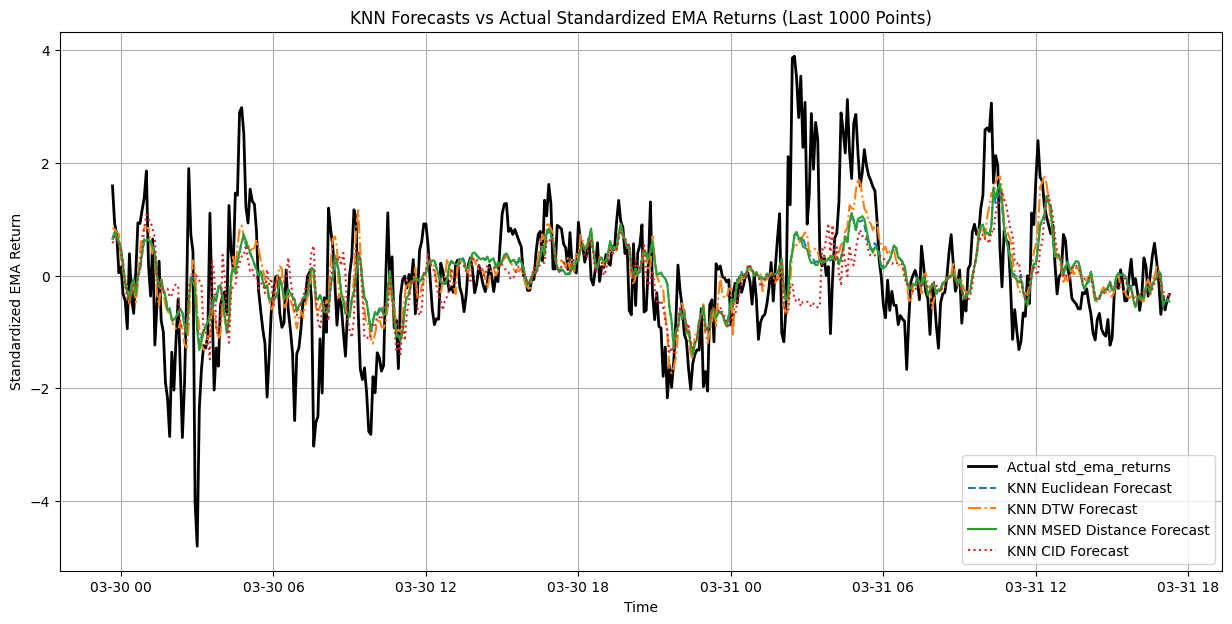

In [60]:

plot_range = -500 # Range

plt.figure(figsize=(15, 7)) 

# Plot Actual Data
plt.plot(df.index[plot_range:], df["std_ema_returns"][plot_range:], label='Actual std_ema_returns', color='black', linewidth=2)

# Plot Forecasts
plt.plot(df.index[plot_range:], df["knn_euc_pred"][plot_range:], label='KNN Euclidean Forecast', linestyle='--')
plt.plot(df.index[plot_range:], df["knn_dtw_pred"][plot_range:], label='KNN DTW Forecast', linestyle='-.') 
plt.plot(df.index[plot_range:], df["knn_msed_pred"][plot_range:], label='KNN MSED Distance Forecast', linestyle='-')
plt.plot(df.index[plot_range:], df["knn_cid_pred"][plot_range:], label='KNN CID Forecast', linestyle=':')

plt.title('KNN Forecasts vs Actual Standardized EMA Returns (Last 1000 Points)')
plt.xlabel('Time')
plt.ylabel('Standardized EMA Return')
plt.legend()
plt.grid(True) # Add grid for easier reading
plt.show()

Immediately, one can observe that the four forecast lines are smoother and have much lower amplitude in swings than the actual standardized EMA returns (black line). This is because the prediction at each step is a weighted average of the outcomes following the k=20 nearest historical neighbors; extreme values present in the actual data tend to be averaged out, resulting in a less volatile forecast series.

Visually, all four forecasts appear to capture the general directional movements and medium-term trends of the actual standardized EMA returns. They rise when the actual series trends up and fall when it trends down, indicating that the KNN model is identifying relevant historical patterns to some extent. However, there is a noticeable lag, and the forecasts consistently fail to reach the peaks and troughs seen in the actual data.

Comparing the metrics, the DTW forecast (orange dotted line) sometimes exhibits slightly different dynamics, for instance capturing the upward swing around 03-30 09:00 perhaps slightly more strongly than the other metrics in that specific instance. However, visual inspection alone is subjective and insufficient to determine overall superiority. While the plot provides intuition, quantifications of accuracy and reliability using various error metrics are needed for a proper evaluation.

Before proceeding to the summary error metrics, this plot examines the forecast residuals (Actual - Predicted values) over time for each of the four distance metrics. Each subplot displays the errors for one metric, with a horizontal red dashed line indicating zero error (a perfect forecast).

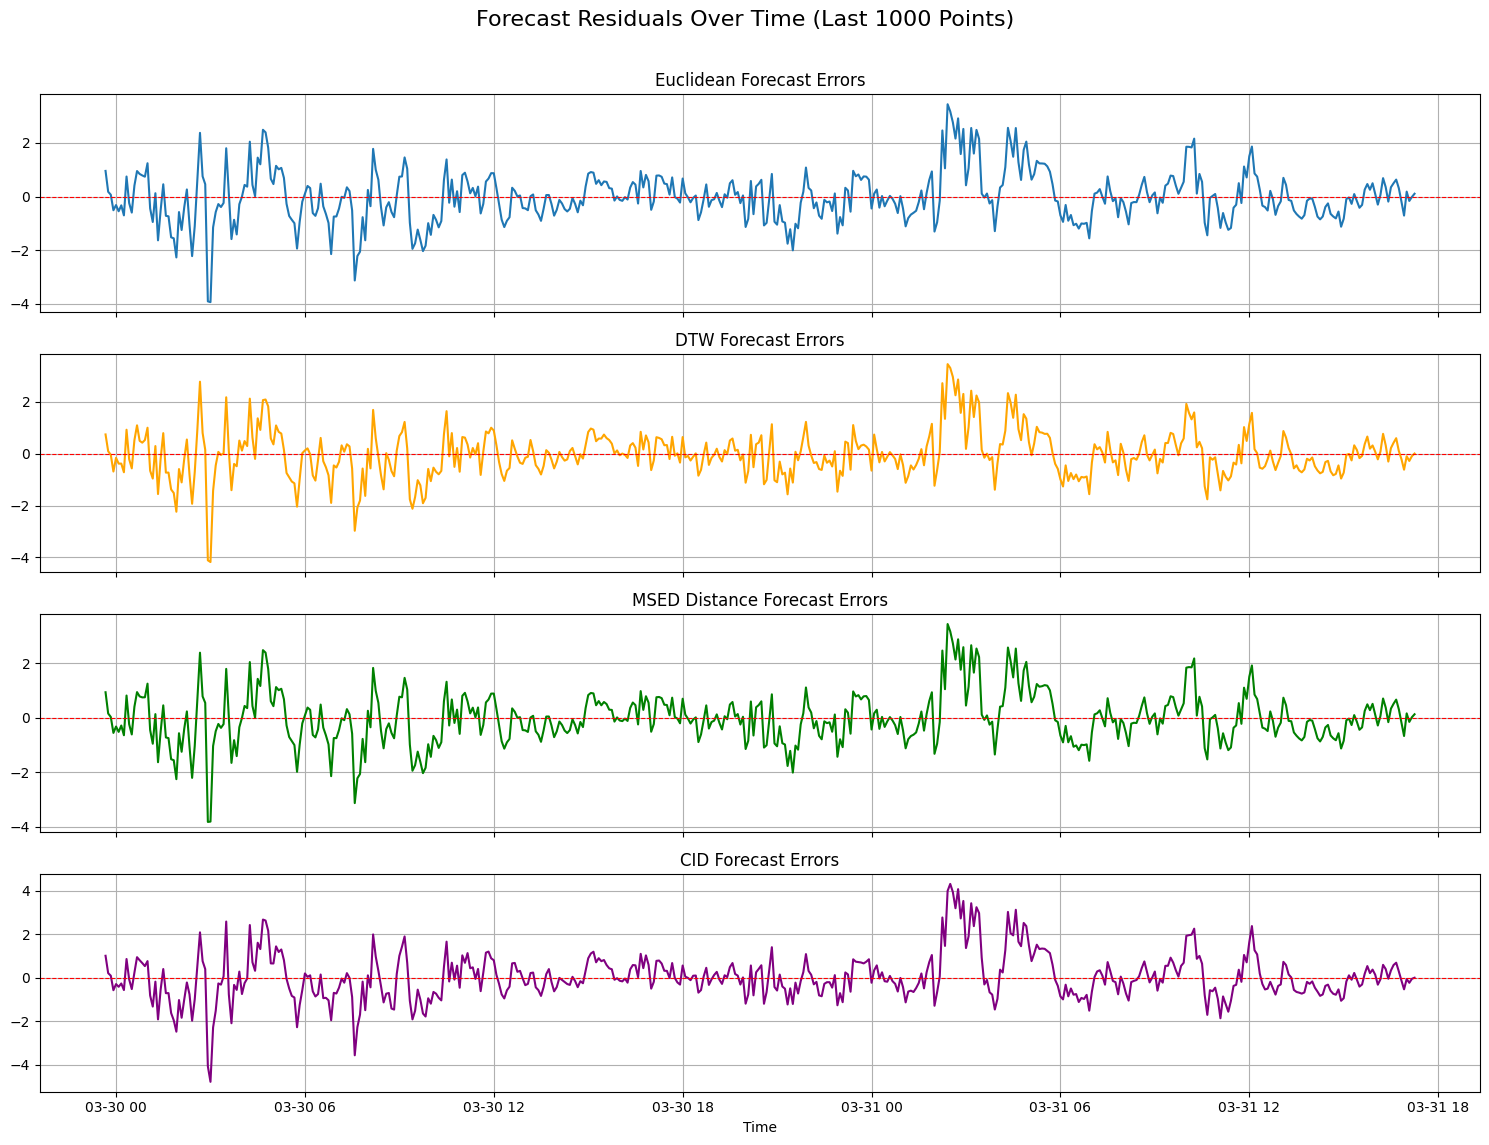

In [ ]:
df['euc_error'] = df["std_ema_returns"] - df["knn_euc_pred"]
df['dtw_error'] = df["std_ema_returns"] - df["knn_dtw_pred"]
df['msed_error'] = df["std_ema_returns"] - df["knn_msed_pred"]
df['cid_error'] = df["std_ema_returns"] - df["knn_cid_pred"]

fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True) # 4 rows, 1 col, share x-axis

axs[0].plot(df.index[plot_range:], df['euc_error'][plot_range:], label='Euclidean Error')
axs[0].set_title('Euclidean Forecast Errors')
axs[0].axhline(0, color='red', linestyle='--', linewidth=0.8) # Add zero line
axs[0].grid(True)

axs[1].plot(df.index[plot_range:], df['dtw_error'][plot_range:], label='DTW Error', color='orange')
axs[1].set_title('DTW Forecast Errors')
axs[1].axhline(0, color='red', linestyle='--', linewidth=0.8)
axs[1].grid(True)

axs[2].plot(df.index[plot_range:], df['msed_error'][plot_range:], label='MSED Distance Error', color='green')
axs[2].set_title('MSED Distance Forecast Errors')
axs[2].axhline(0, color='red', linestyle='--', linewidth=0.8)
axs[2].grid(True)

axs[3].plot(df.index[plot_range:], df['cid_error'][plot_range:], label='CID Error', color='purple')
axs[3].set_title('CID Forecast Errors')
axs[3].axhline(0, color='red', linestyle='--', linewidth=0.8)
axs[3].grid(True)
axs[3].set_xlabel('Time')


fig.suptitle('Forecast Residuals Over Time ', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap
plt.show()

Comparing the residual error plots with the first plot (showing actual standardized EMA returns), a clear pattern emerges: forecast errors tend to increase significantly during periods where the actual returns undergo large changes. This confirms that the forecasts struggle most with accuracy when the underlying series is volatile or experiencing sharp swings.

For example, all metrics exhibit substantial errors during the sharp downswing observed around 03-30 03:00 in the actual data, as the smoothed forecasts could not replicate this rapid move.

Comparing the different metrics within the residual plots, we can sometimes observe performance differences. For instance, around 03-31 03:00, the CID forecast appears to generate noticeably larger errors relative to the other metrics during that specific period. However, during other events, like the large downswing at 03-30 03:00 mentioned earlier, the magnitude of errors seems roughly comparable across all methods.

These specific visual observations highlight that relative performance can vary depending on the market dynamics at the time. This reinforces the need for aggregated, quantitative error metrics to assess the overall average performance of each distance metric across the entire test period.

#### Evaluating Forecast Accuracy: Error Metrics

To quantitatively compare the performance of the KNN forecasts generated using different distance metrics, objective measures are needed. In comes MAE, MSE, RMSE, and NMAE:


##### 1.  The Mean Absolute Error (MAE) 

The Mean Absolute Error (MAE)  calculates the average of the absolute differences between the actual and predicted returns. Unlike MSE, MAE gives equal weight to all errors, regardless of their size. This makes MAE a useful metric when you want to evaluate the average magnitude of errors without giving excessive importance to large deviations. A lower MAE indicates better performance, and it is less sensitive to outliers compared to MSE.

**Formula:**
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$
Where:
- $y_i$ is the actual returns
- $\hat{y}_i$ is the predicted returns
- $n$ is the number of observations

##### 2. Mean Squared Error (MSE)

The Mean Squared Error (MSE) calculates the average of the squared differences between the actual and predicted returns. Unlike MAE, MSE gives more weight to larger errors due to the squaring of the differences. This can be useful when the model needs to penalize large deviations more heavily. A lower MSE indicates better performance, but it is sensitive to outliers. [6]

**Formula:**
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
Where:
- $y_i$ is the actual returns
- $\hat{y}_i$ is the predicted returns
- $n$ is the number of observations

##### 3. Root Mean Squared Error (RMSE)

The Root Mean Squared Error (RMSE) is the square root of the Mean Squared Error. RMSE provides an error metric that is in the same units as the target variable, making it more interpretable than MSE. Like MSE, RMSE is sensitive to large errors, and thus it can be useful when the model needs to give higher penalties to larger prediction errors. A lower RMSE indicates better performance. [6]

**Formula:**
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$
Where:
- $y_i$ is the actual returns
- $\hat{y}_i$ is the predicted returns
- $n$ is the number of observations

##### 4. Normalized Mean Absolute Error (NMAE)

The Normalized Mean Absolute Error (NMAE) is a variant of MAE that is normalized by the range of the actual values. It provides a scale-independent measure of error, which is useful when comparing performance across different datasets or models with different magnitudes. The lower the NMAE, the better the model performs in predicting volatility-adjusted returns, relative to the range of the returns.

**Formula:**
$$
\text{NMAE} = \frac{\text{MAE}}{\text{max}(y) - \text{min}(y)}
$$
Where:
- $\text{MAE}$ is the Mean Absolute Error
- $\text{max}(y)$ is the maximum value of the returns
- $\text{min}(y)$ is the minimum value of the returns

Having defined MAE, MSE, RMSE, and NMAE, they can now be implemented and calculated to quantitatively evaluate the performance of our KNN forecasts. Primary analysis and results table on **MAE** and **RMSE**.

Here's the rationale for this focus:

*   **MAE:** Provides the most direct interpretation of the average forecast error magnitude.
*   **RMSE:** Usefully complements MAE by highlighting the impact of larger errors (due to the squaring). Since it's in the same units as the target variable (standardized returns), it remains interpretable. It inherently captures the information from MSE while being easier to relate to the scale of the data.
*   **MSE:** While calculated as an intermediate step to get RMSE, displaying both MSE and RMSE in the comparison table is often redundant as they rank models identically. We prioritize RMSE for its interpretability.
*   **NMAE:** Given that the target variable "std_ema_returns" has already been standardized, the need for further normalization via NMAE to compare metrics is reduced. MAE and RMSE on the standardized data already provide a reasonable basis for comparison in this context.

The following Python code implements the calculation of MAE and RMSE for the forecasts generated by each distance metric (Euclidean, DTW, MSE Distance, and CID). It ensures that comparisons are made only over the time steps where both actual values and predictions are available (handling initial period where window is too small for forecasting).

In [71]:
results = {}

actual_col = 'std_ema_returns'
pred_cols = ['knn_euc_pred', 'knn_dtw_pred', 'knn_msed_pred', 'knn_cid_pred']
metric_names = ['Euclidean', 'DTW', 'MSE Dist', 'CID'] 

for i, pred_col in enumerate(pred_cols): #indexing through every column in pred_cols.

    comparison_df = df[[actual_col, pred_col]].copy() # Create copy of database to drop NaN values.
    comparison_df.dropna(inplace=True) # Dropping NaN values

    actual = comparison_df[actual_col]
    predicted = comparison_df[pred_col] 

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted) # Calculate MSE used for RMSE
    rmse = np.sqrt(mse) # Then take the square root for RMSE

    metric_name = metric_names[i]
    results[metric_name] = {'MAE': mae, 'RMSE': rmse}

# Display results in a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

print("\n--- Quantitative Error Metrics ---")
print(results_df)


--- Quantitative Error Metrics ---
                MAE      RMSE
Euclidean  0.653399  0.894614
DTW        0.621626  0.860971
MSE Dist   0.651260  0.891668
CID        0.703263  0.976644


Result is shown below:

| Metric       |     MAE |    RMSE |
| :----------- | ------: | ------: |
| Euclidean    |  0.6534 |  0.8946 |
| DTW          |  0.6216 |  0.8610 |
| MSE Distance |  0.6513 |  0.8917 |
| CID          |  0.7033 |  0.9766 |

*(Note: These values were generated using the parameters specified earlier: window_size=240, embed_size=15, k=20 and time-frame 03-01-2021 00:00 to 03-031-2021 17:15)*

Based on these results:

Dynamic Time Warping (DTW) emerges as the top-performing metric, achieving the lowest MAE (0.6216) and the lowest RMSE (0.8610). This suggests that its ability to flexibly align time series patterns provided the most consistently accurate predictions for this dataset and parameter set, minimizing both average error magnitude and the impact of large errors.

Euclidean Distance and MSE Distance show very similar performance (MAE ≈ 0.65, RMSE ≈ 0.89), performing noticeably worse than DTW but significantly better than CID. Their close results are expected given their mathematical relationship.

Complexity-Invariant Distance (CID) performed the poorest, yielding the highest MAE (0.7033) and RMSE (0.9766). The attempt by CID to adjust for sequence complexity did not translate into better accuracy here; instead, it resulted in the largest average errors and was likely more susceptible to significant prediction misses.

Therefore, for this specific forecasting task on standardized EMA returns of GBP/USD within the given timeframe and using the chosen KNN parameters, DTW appears to be the most effective distance metric among those tested.

Beyond comparing the metrics to each other, one can consider the absolute magnitude of the errors. The best performing metric, DTW, yielded an MAE of approximately 0.62 and an RMSE of approximately 0.86. Given that the target variable "std_ema_returns" is standardized, its standard deviation is expected to be near 1.0.

An MAE of 0.62 suggests the average forecast error is about 62% of a typical standard deviation movement, which is a substantial error relative to the data's scale. Similarly, an RMSE of 0.86 indicates that the model captures only a limited portion of the actual variance (roughly $1 - 0.86^2 ≈ 26%$).

Therefore, while DTW was the most effective distance metric found here, the overall predictive accuracy of the KNN model with these parameters appears limited in an absolute sense.

## References
[1] James Chen. (2024). [What is EMA? How to Use Exponential Moving Average With Formula](https://www.investopedia.com/terms/e/ema.asp)

[2] G. E. A. P. A. Batista, X. Wang, and E. J. Keogh, "A Complexity-Invariant Distance Measure for Time Series,"

[3] GeeksForGeeks (2023). [Similarity Search for Time-Series Data](https://www.geeksforgeeks.org/similarity-search-for-time-series-data/)

[4] Romain Tavenard [An introduction to Dynamic Time Warping](https://rtavenar.github.io/blog/dtw.html)

[5] GeeksForGeeks (2024). [Dynamic Time Warping (DTW) in Time Series](https://www.geeksforgeeks.org/dynamic-time-warping-dtw-in-time-series/)

[6] jedox. [Error Metrics: How to Evaluate Your Forecasts](https://www.jedox.com/en/blog/error-metrics-how-to-evaluate-forecasts/)